In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from PIL import Image

In [3]:
img_dir = 'data/images'
mask_dir = 'data/masks'

In [4]:
class img_mask_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mask_dir, transforms):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(self.img_dir)))
        self.masks = list(sorted(os.listdir(self.mask_dir)))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert('L')
        og_shape = img.size
        
        # Reduce image size
        downsize = T.Resize((500, 500))
        img = downsize(img)
        mask = downsize(mask)
        
        # convert the PIL Image into a numpy array
        img = np.array(img)
        img = torch.as_tensor(img, dtype=torch.uint8)
        
        mask = np.array(mask)
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.reshape(mask.shape[0], mask.shape[1], 1)

        if self.transforms is not None:
            img, mask = self.transforms(img, mask)
            
        return img, mask, (og_shape[1], og_shape[0])

    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = img_mask_Dataset(img_dir, mask_dir, None)

In [6]:
img, mask, shape = dataset[0]

In [7]:
shape

(1620, 1080)

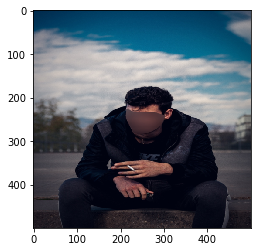

In [8]:
plt.imshow(img)

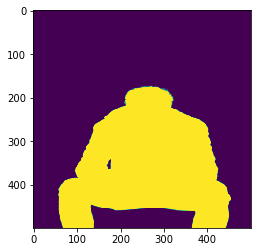

In [9]:
mask_p = mask.reshape(mask.shape[0], mask.shape[1])
plt.imshow(mask_p)

In [10]:
mask[mask == 255] = 1

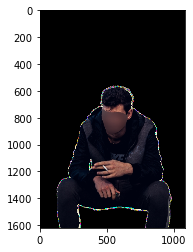

In [11]:
cut = img * mask
restore_og_shape = T.Resize(shape)
plt.imshow(restore_og_shape(Image.fromarray(cut.numpy())))

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input format: CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
       
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# Create Custom Loss Function
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1-IoU

In [17]:
# split into train- and val sets
val_size = 0.01
batch_size = 4
n_val = int(len(dataset) * val_size)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=True, drop_last=True, batch_size=1, num_workers=4, pin_memory=True)

In [18]:
def train(net, dataset, epochs=10, lr=1e-5):    
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
    criterion = IoULoss()
    
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        for batch in train_loader:
            img = batch[0].permute(0, 3, 1, 2)
            mask = batch[1].permute(0, 3, 1, 2)
            mask[mask == 255] = 1
            
            img = img.type(torch.FloatTensor).to(device)
            mask = mask.type(torch.FloatTensor).to(device)
            mask_pred = net(img)
            
            loss = criterion(mask_pred, mask)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            #print('Batch Loss: ', loss.item())
        print(f'Epoch {epoch} Loss: {epoch_loss}')
    

In [19]:
net = UNet(n_channels=3, n_classes=1).to(device)

In [23]:
train(net, train_loader, epochs=25, lr=1e-5)

Epoch 0 Loss: -17759.47615325451
Epoch 1 Loss: -17905.840339899063
Epoch 2 Loss: -18139.98011112213
Epoch 3 Loss: -18241.595988988876
Epoch 4 Loss: -18532.546830892563
Epoch 5 Loss: -18779.011751413345
Epoch 6 Loss: -18574.278757095337
Epoch 7 Loss: -18754.189014196396
Epoch 8 Loss: -19138.298124313354
Epoch 9 Loss: -19201.759158611298
Epoch 10 Loss: -19266.49781870842
Epoch 11 Loss: -19358.179927825928
Epoch 12 Loss: -19342.817306756973
Epoch 13 Loss: -19337.358418941498
Epoch 14 Loss: -19685.099784612656
Epoch 15 Loss: -19674.34234213829
Epoch 16 Loss: -19715.83687019348
Epoch 17 Loss: -19862.08424425125
Epoch 18 Loss: -19900.45650291443
Epoch 19 Loss: -19988.37470293045
Epoch 20 Loss: -20036.008597135544
Epoch 21 Loss: -19725.19168114662
Epoch 22 Loss: -19962.47688817978
Epoch 23 Loss: -20086.979338169098
Epoch 24 Loss: -20201.697481632233


In [24]:
iter_ = iter(val_loader)

<ipython-input-26-671bdabe07e7>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(20,20))


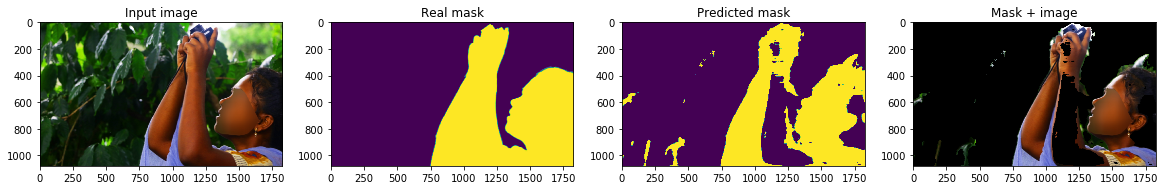

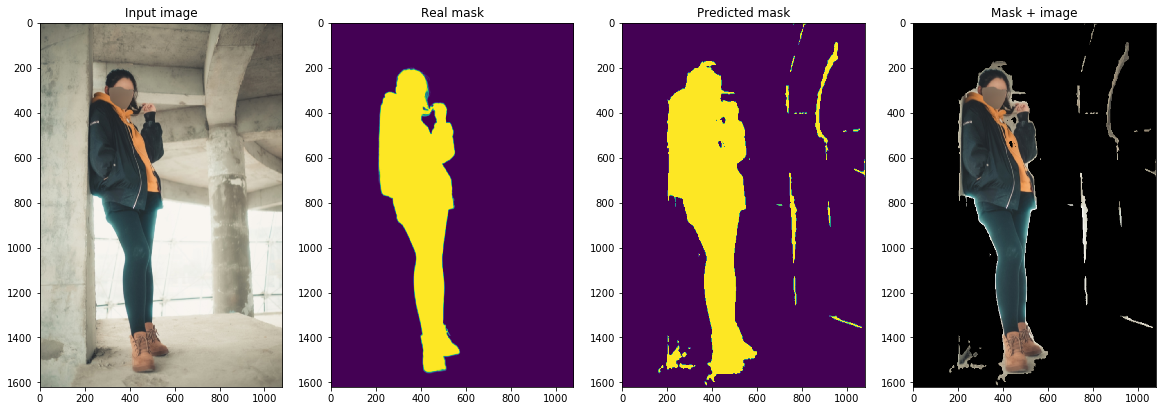

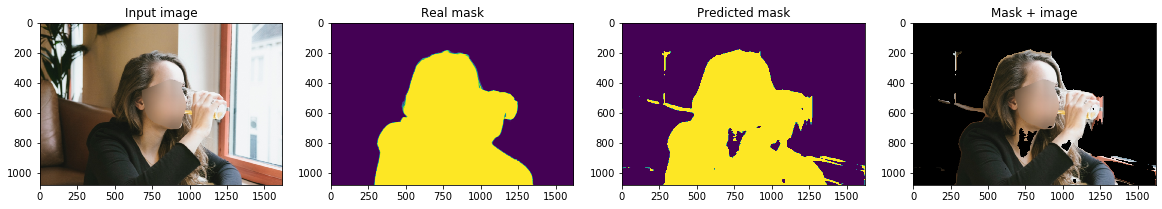

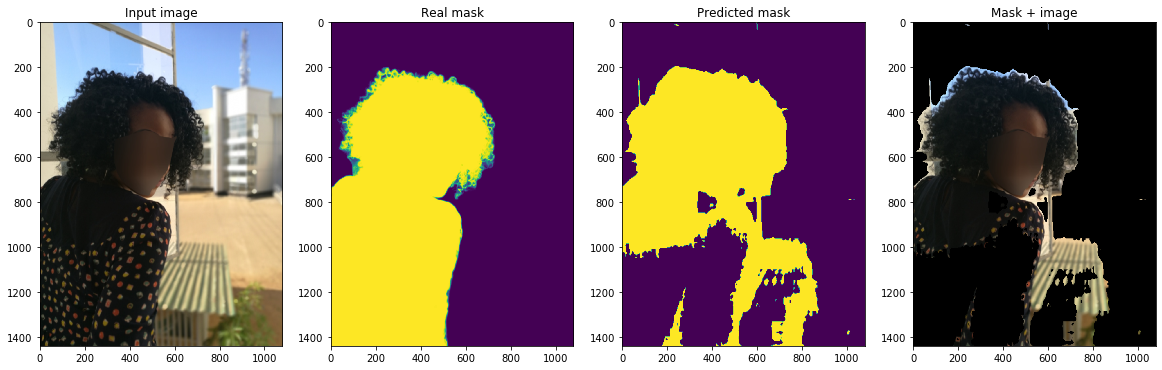

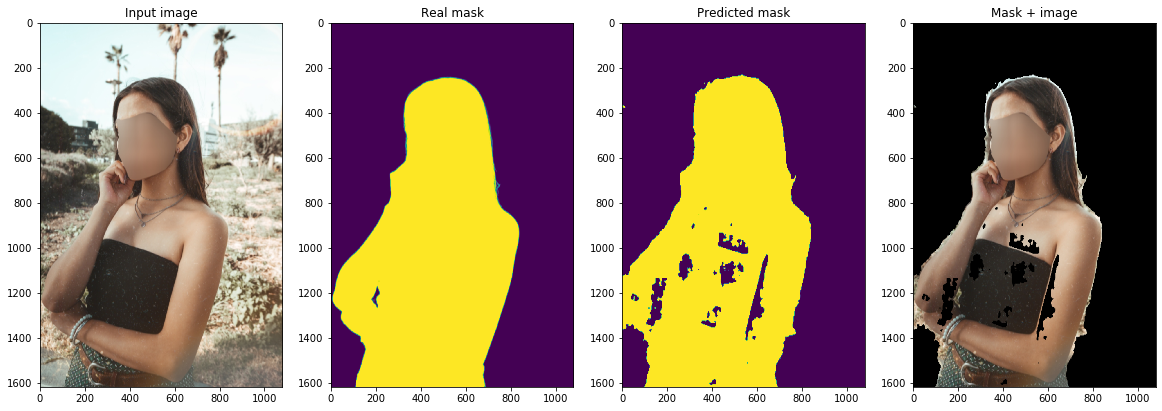

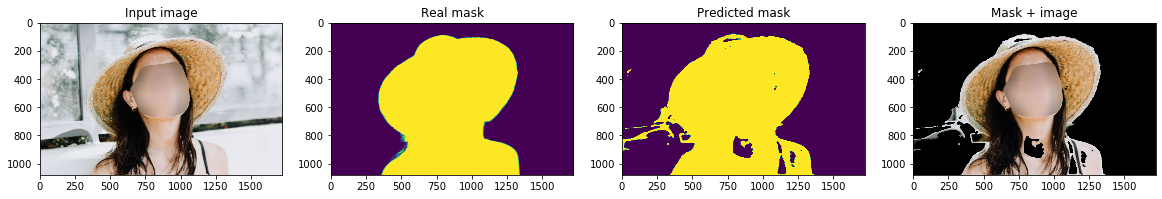

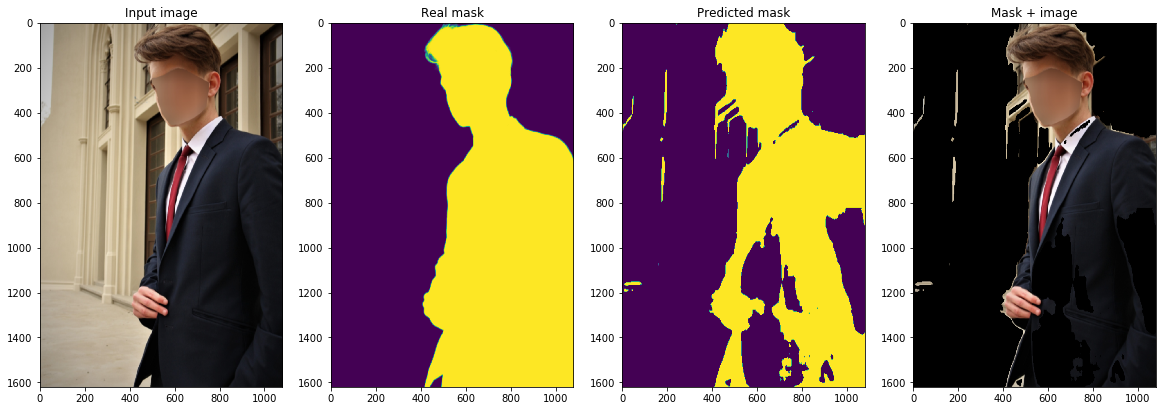

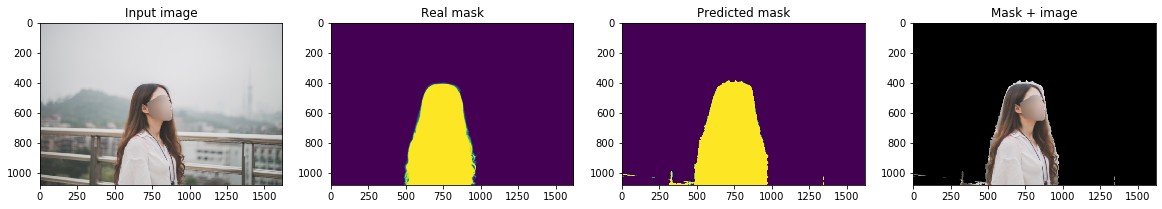

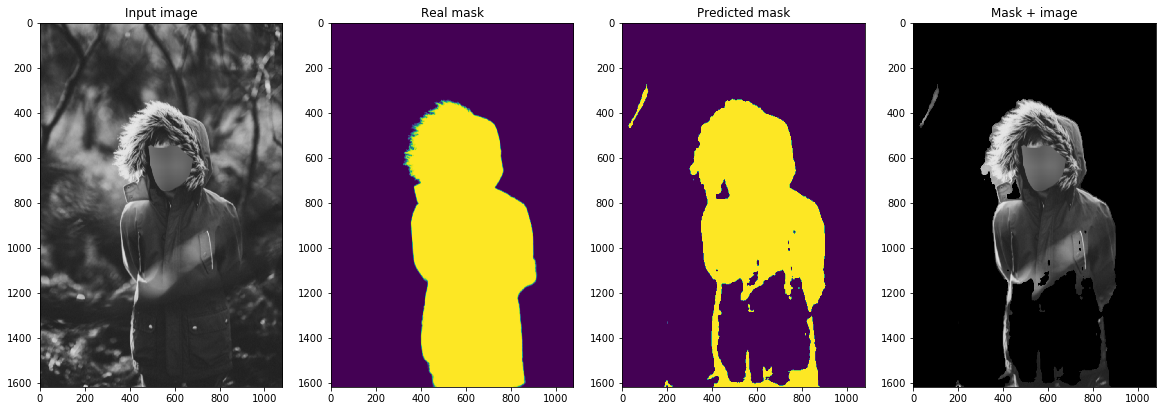

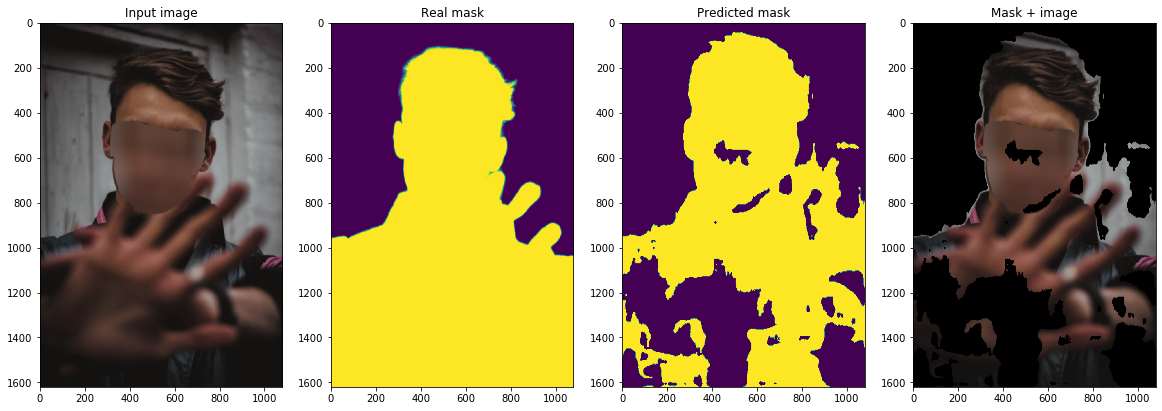

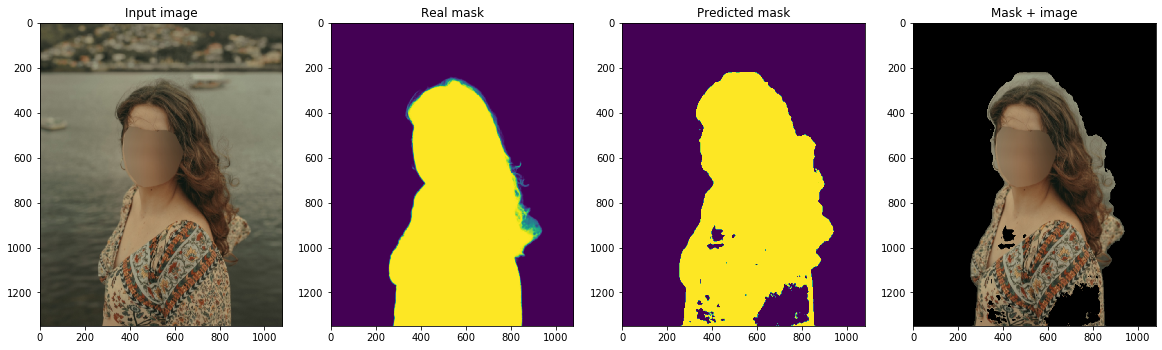

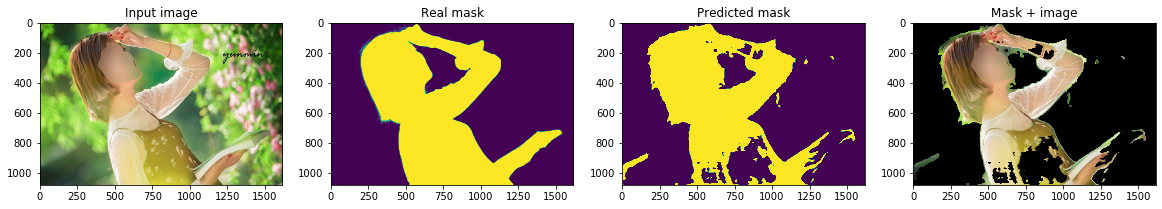

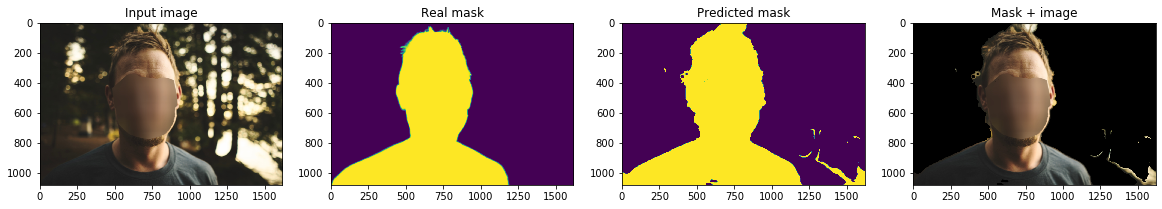

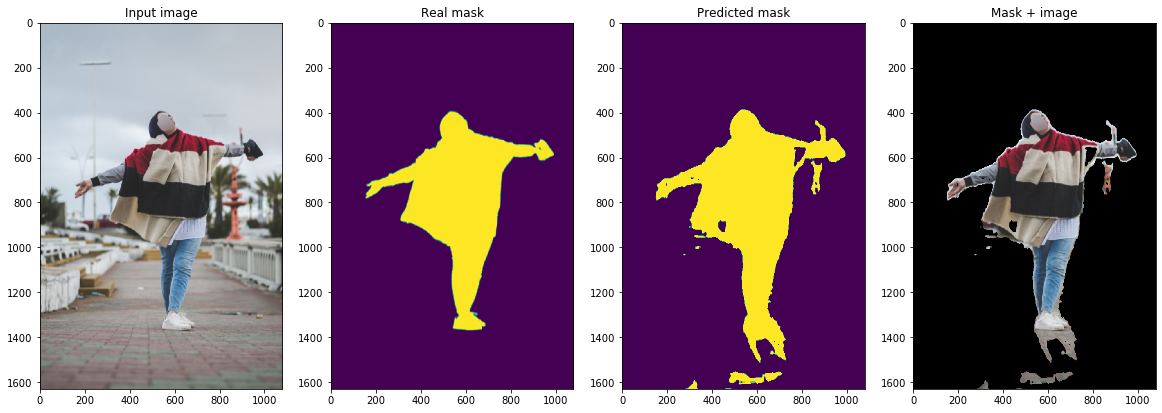

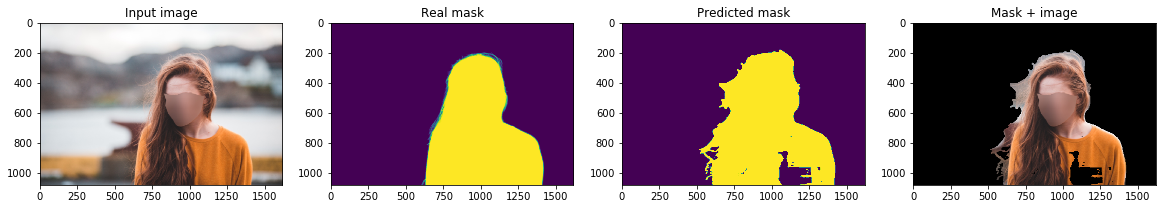

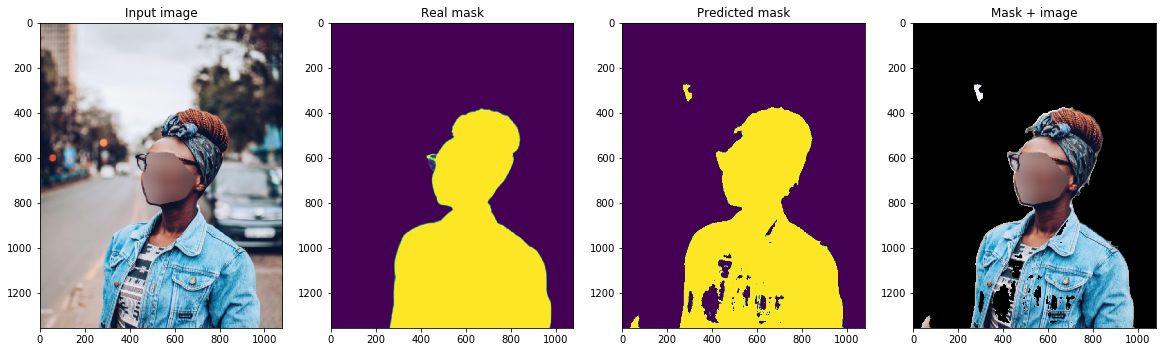

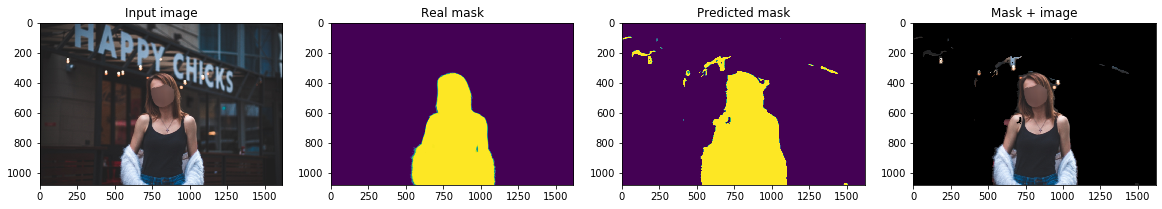

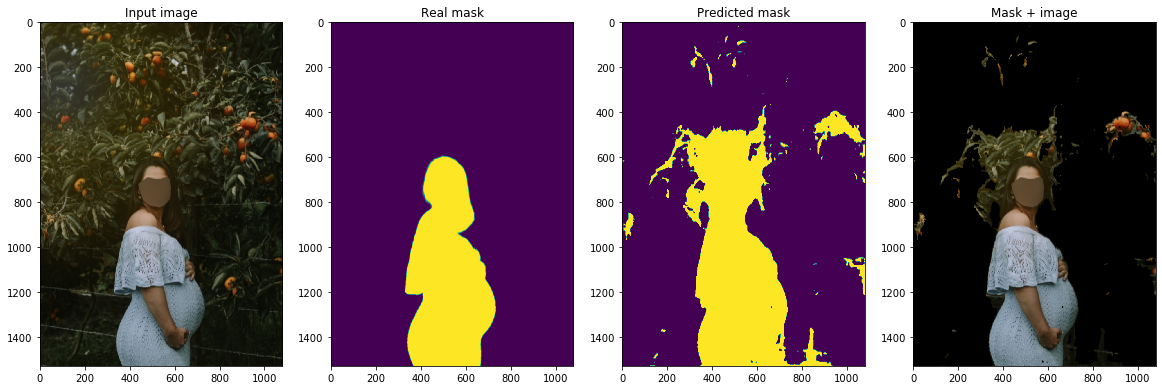

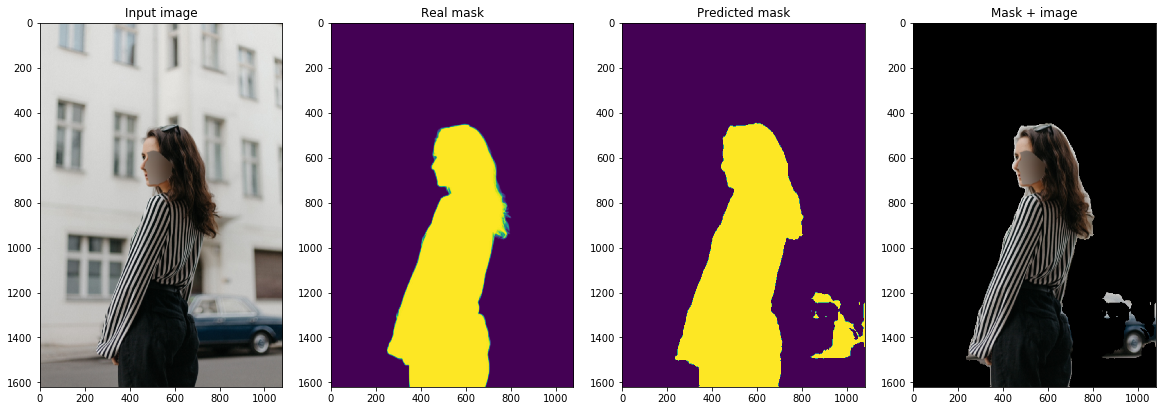

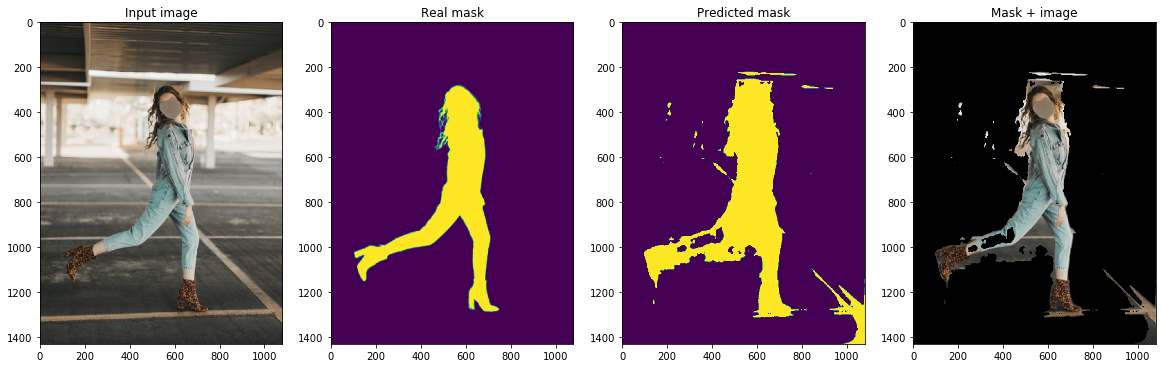

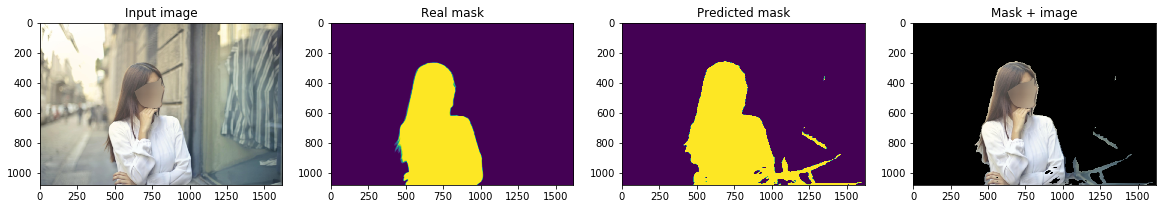

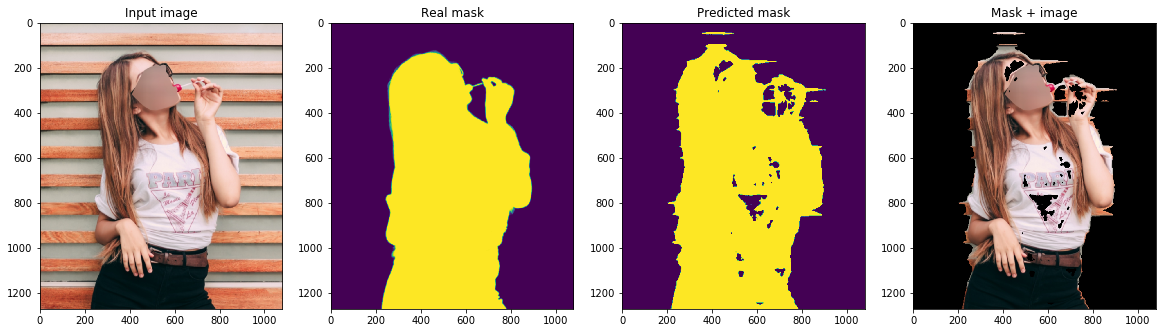

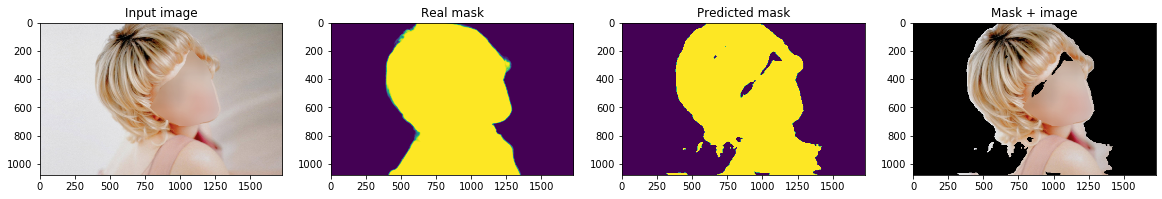

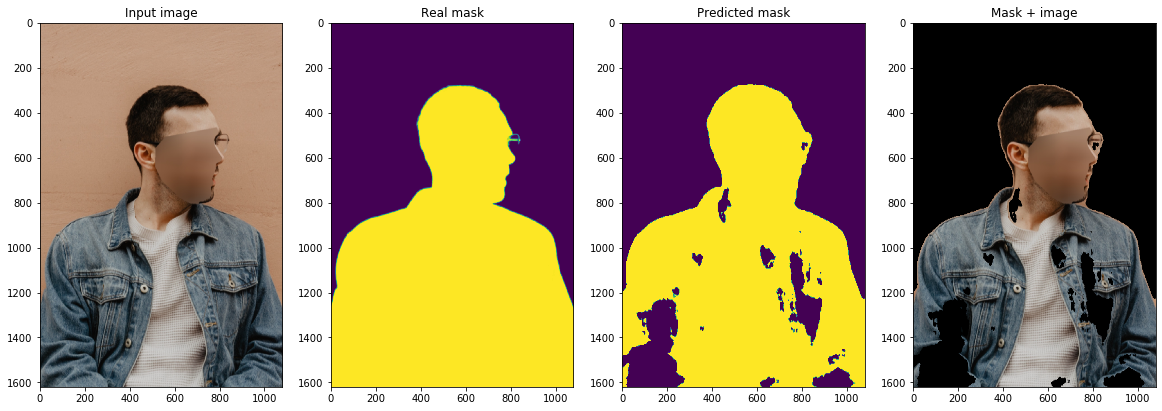

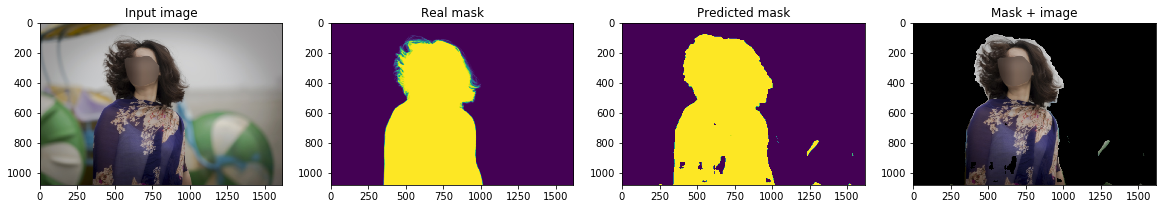

In [26]:
for _ in range(25):
    img, mask, shape = next(iter_)
    img_in = img.permute(0, 3, 1, 2).type(torch.FloatTensor).to(device)
    mask = mask[0].reshape(mask.shape[1], mask.shape[2])
    out = net(img_in)[0].permute(1, 2, 0).reshape(mask.shape[0], mask.shape[1]).detach().cpu()
    mask_pred = np.zeros(out.shape)
    mask_pred[out>0.5] = 1
    #cut = (img[0] * mask_pred.reshape(mask_pred.shape[0], mask_pred.shape[1], 1)).type(torch.IntTensor)
    
    transform = T.Resize(shape)
    img = transform(Image.fromarray(img[0].numpy()))
    mask = transform(Image.fromarray(mask.numpy()))
    mask_pred = transform(Image.fromarray(mask_pred))
    cut = (np.array(img) * np.array(mask_pred).reshape(shape[0], shape[1], 1)).astype(np.uint8)
    
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(img)
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(mask)
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(np.array(mask_pred))
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(cut)

# Saving The Model

In [27]:
torch.save(net.state_dict(), 'Models/net2.pt')